

1.   Name: Devesh Ashish Vyas.
2.   Roll no: 70. Semester: VII.
3.   Section: B. Batch: B4.
4.   Practical-10. Project.
5.   Date: 24/10/25.



# Project: Uncertainty Quantification in Deep Learning for Image Classification

## Problem Statement

Standard Deep Learning models, such as Convolutional Neural Networks (CNNs), are powerful but have a significant flaw: they are often **overconfident**. A standard CNN will output a prediction (e.g., "This is a '5'") with high confidence, even when it is wrong.

Furthermore, they have no reliable mechanism to identify **Out-of-Distribution (OOD)** data. If a model is trained only on handwritten digits (0-9), and you show it a picture of a cat, it will still confidently (and incorrectly) classify it as one of the digits. This lack of "self-awareness" is dangerous for real-world applications like medical diagnosis or autonomous driving.

This project solves this problem by exploring, analyzing, and applying **Probabilistic Deep Learning (PDL)** models. These models are designed to quantify their own uncertainty, allowing them to:
1.  Express low confidence on ambiguous or difficult predictions.
2.  Signal high uncertainty when faced with novel OOD data.

# 1. Setup and Import Libraries

In [1]:
# %%capture
# # 1. SETUP & IMPORTS
# # Install TensorFlow Probability
!pip install tensorflow_probability

# --- FIX: Force Keras 2 behavior for TFP compatibility ---
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
# ---------------------------------------------------------

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define aliases
tfd = tfp.distributions
tpl = tfp.layers

print(f"TensorFlow Version: {tf.__version__}")
print(f"TensorFlow Probability Version: {tfp.__version__}")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

TensorFlow Version: 2.19.0
TensorFlow Probability Version: 0.25.0


# 2. Load and Preprocess Data

In [3]:
# ---
# 2. LOAD & PREPROCESS DATA
# ---

def preprocess_data(images, labels):
    """Normalize images and cast labels."""
    images = tf.cast(images, tf.float32) / 255.0
    # Add a channel dimension for Conv2D
    images = images[..., tf.newaxis]
    labels = tf.cast(labels, tf.int64)
    return images, labels

# Load In-Distribution (ID) Data: MNIST
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()
x_train_mnist, y_train_mnist = preprocess_data(x_train_mnist, y_train_mnist)
x_test_mnist, y_test_mnist = preprocess_data(x_test_mnist, y_test_mnist)

print(f"MNIST Train shapes: {x_train_mnist.shape}, {y_train_mnist.shape}")
print(f"MNIST Test shapes: {x_test_mnist.shape}, {y_test_mnist.shape}")

# Load Out-of-Distribution (OOD) Data: Fashion-MNIST
(x_test_fashion, y_test_fashion) = tf.keras.datasets.fashion_mnist.load_data()[1]
x_test_fashion, y_test_fashion = preprocess_data(x_test_fashion, y_test_fashion)

print(f"Fashion-MNIST Test shapes: {x_test_fashion.shape}, {y_test_fashion.shape}")

# Create TF Datasets
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_mnist, y_train_mnist)).batch(BATCH_SIZE)
test_dataset_mnist = tf.data.Dataset.from_tensor_slices((x_test_mnist, y_test_mnist)).batch(BATCH_SIZE)
test_dataset_fashion = tf.data.Dataset.from_tensor_slices((x_test_fashion, y_test_fashion)).batch(BATCH_SIZE)

MNIST Train shapes: (60000, 28, 28, 1), (60000,)
MNIST Test shapes: (10000, 28, 28, 1), (10000,)
Fashion-MNIST Test shapes: (10000, 28, 28, 1), (10000,)


# 3. Model 1: Standard (Deterministic) CNN [Baseline]

In [4]:
# ---
# 3. MODEL 1: STANDARD (DETERMINISTIC) CNN [BASELINE]
# ---

def create_standard_cnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10)  # Output logits
    ])
    return model

model_standard = create_standard_cnn()
model_standard.summary()

# Compile and train
model_standard.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("\n--- Training Standard CNN ---")
model_standard.fit(train_dataset, epochs=5, validation_data=test_dataset_mnist)

print("\nStandard CNN Performance on MNIST (In-Distribution):")
model_standard.evaluate(test_dataset_mnist)

print("\nStandard CNN Performance on Fashion-MNIST (Out-of-Distribution):")
model_standard.evaluate(test_dataset_fashion)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 32)                1

[5.481884956359863, 0.08910000324249268]

# 4. Model 2: Monte Carlo (MC) Dropout [Technique-01]

In [5]:
# ---
# 4. MODEL 2: MONTE CARLO (MC) DROPOUT [TECHNIQUE 1]
# ---

# We define a new model that includes Dropout layers.
# The key is to keep these layers active (training=True) during inference.

def create_mc_dropout_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),  # Dropout after pooling
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),  # Dropout after pooling
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),   # Dropout before final layer
        tf.keras.layers.Dense(10)       # Output logits
    ])
    return model

model_mc_dropout = create_mc_dropout_model()
model_mc_dropout.summary()

# Compile and train (same as before)
model_mc_dropout.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("\n--- Training MC Dropout Model ---")
model_mc_dropout.fit(train_dataset, epochs=5, validation_data=test_dataset_mnist)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 8)         0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 13, 13, 8)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 16)        1168      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 16)         

# 5. Model 3: Bayesian Neural Network (BNN) [Technique-02]

In [6]:
# ---
# 5. MODEL 3: BAYESIAN NEURAL NETWORK (BNN) [TECHNIQUE 2]
# ---

# We use TFP's special layers (DenseFlipout) that maintain distributions over weights.
# The loss function is more complex: it combines the data likelihood (NLL)
# with a model complexity penalty (KL divergence).

# Define the KL divergence loss component
def kl_divergence_loss(model):
    # Sum of KL divergences for all layers
    return sum(model.losses)

# Define the Negative Log-Likelihood (NLL)
def negative_log_likelihood(y_true, y_pred_dist):
    # y_pred_dist is a tfd.Distribution object (e.g., Categorical)
    # We get the log-probability of the true labels under this distribution
    return -tf.reduce_mean(y_pred_dist.log_prob(y_true))

# Create the BNN model
def create_bnn_model():
    # We use 'Flipout' layers, a form of Variational Inference
    model = tf.keras.Sequential([
        # --- FIX: Add an InputLayer to explicitly define the input shape ---
        tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),

        # --- Remove 'input_shape' from the Conv2D layer below ---
        tf.keras.layers.Conv2D(8, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        # Use TFP's DenseFlipout layer
        tpl.DenseFlipout(
            32,
            activation='relu',
            kernel_posterior_fn=tpl.default_mean_field_normal_fn(),
            bias_posterior_fn=tpl.default_mean_field_normal_fn()
        ),
        # The final layer outputs the parameters for a distribution
        tpl.DenseFlipout(
            10,  # 10 classes
            kernel_posterior_fn=tpl.default_mean_field_normal_fn(),
            bias_posterior_fn=tpl.default_mean_field_normal_fn()
        ),
        # Convert the 10 logits into a Categorical distribution
        tpl.DistributionLambda(lambda t: tfd.Categorical(logits=t))
    ])
    return model

model_bnn = create_bnn_model()

# Compile the BNN
# The loss is NLL + KL divergence
# The KL divergence is added as a layer-wise loss, so we can just use NLL here
# But we must add the model.losses to the total loss
def total_loss(y_true, y_pred_dist):
    nll = negative_log_likelihood(y_true, y_pred_dist)
    kl = kl_divergence_loss(model_bnn)
    return nll + kl / BATCH_SIZE # Scale KL by batch size

model_bnn.compile(
    optimizer='adam',
    loss=total_loss, # Use our combined loss
    metrics=['accuracy'] # Keras measures accuracy based on y_pred_dist.mean()
)

print("\n--- Training BNN Model ---")
model_bnn.fit(train_dataset, epochs=5, validation_data=test_dataset_mnist)

/usr/local/lib/python3.12/dist-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.12/dist-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(
/usr/local/lib/python3.12/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(



--- Training BNN Model ---
Epoch 1/5
469/469 [==============================] - 24s 47ms/step - loss: 30418.7363 - accuracy: 0.0640 - val_loss: 27430.7461 - val_accuracy: 0.0759
Epoch 2/5
469/469 [==============================] - 17s 36ms/step - loss: 24533.4199 - accuracy: 0.0362 - val_loss: 21663.0059 - val_accuracy: 0.0633
Epoch 3/5
469/469 [==============================] - 18s 39ms/step - loss: 18915.6113 - accuracy: 0.0576 - val_loss: 16221.7422 - val_accuracy: 0.0380
Epoch 4/5
469/469 [==============================] - 20s 42ms/step - loss: 13711.8770 - accuracy: 0.0704 - val_loss: 11293.1846 - val_accuracy: 0.0506
Epoch 5/5
469/469 [==============================] - 18s 38ms/step - loss: 9136.7432 - accuracy: 0.0597 - val_loss: 7115.1304 - val_accuracy: 0.0506


# 6. Evaluation and Uncertainity Visualization

In [9]:
# ---
# 6. EVALUATION & UNCERTAINTY VISUALIZATION
# ---

# Number of forward passes for probabilistic models
N_SAMPLES = 100

# Helper function for MC Dropout predictions
def predict_mc_dropout(model, x, n_samples=N_SAMPLES):
    # Create a tensor of N_SAMPLES copies of the input batch
    # Shape: (n_samples, batch_size, 28, 28, 1)
    x_stack = tf.stack([x] * n_samples)

    # --- FIX: Reshape to a single large batch ---
    # Get the dynamic batch size from the input tensor x
    batch_size = tf.shape(x)[0]
    # New shape: (n_samples * batch_size, 28, 28, 1)
    x_reshaped = tf.reshape(x_stack, (n_samples * batch_size, 28, 28, 1))

    # Perform inference with dropout active (training=True)
    # Model receives one large batch, output shape: (n_samples * batch_size, 10)
    logits = model(x_reshaped, training=True)

    # Convert logits to probabilities
    probs = tf.nn.softmax(logits, axis=-1)

    # --- FIX: Reshape the output back to (n_samples, batch_size, 10) ---
    probs_reshaped = tf.reshape(probs, (n_samples, batch_size, 10))

    return probs_reshaped

# Helper function for BNN predictions
def predict_bnn(model, x, n_samples=N_SAMPLES):
    # BNNs are stochastic by nature. Calling the model N_SAMPLES times
    # will sample from the weight distributions N_SAMPLES times.
    probs_list = []
    for _ in range(n_samples):
        # model(x) returns a tfd.Categorical distribution
        # .probs_parameter() extracts the probabilities
        probs_list.append(model(x).probs_parameter())

    probs = tf.stack(probs_list)
    return probs # Shape: (n_samples, batch_size, 10)

# Helper function for Standard CNN predictions (for consistency)
def predict_standard(model, x, n_samples=N_SAMPLES):
    # Deterministic model, so all N_SAMPLES will be identical
    logits = model(x, training=False)
    probs = tf.nn.softmax(logits, axis=-1)
    return tf.stack([probs] * n_samples) # Shape: (n_samples, batch_size, 10)

# Helper function to calculate uncertainty (Predictive Entropy)
def predictive_entropy(probs):
    # probs shape: (n_samples, batch_size, 10)
    # 1. Mean over samples
    mean_probs = tf.reduce_mean(probs, axis=0) # Shape: (batch_size, 10)
    # 2. Calculate entropy
    # H(p) = - sum(p * log(p))
    entropy = -tf.reduce_sum(mean_probs * tf.math.log(mean_probs + 1e-9), axis=-1)
    return entropy

# Helper function to plot results
def plot_uncertainty(image, all_probs, title=""):
    # all_probs shape: (3, n_samples, 10) [Standard, MC, BNN]
    # We'll plot for a single image, so let's squeeze
    # New shape: (3, n_samples, 10)

    titles = ["Standard CNN", "MC Dropout", "BNN (TFP)"]
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), gridspec_kw={'height_ratios': [1, 1.5]})
    fig.suptitle(title, fontsize=20)

    for i, (model_title, probs) in enumerate(zip(titles, all_probs)):
        # probs shape: (n_samples, 10)

        # 1. Plot the image
        ax_img = axes[0, i]
        ax_img.imshow(image, cmap='gray')
        ax_img.set_title(f"{model_title}", fontsize=16)
        ax_img.axis('off')

        # 2. Plot the probability distributions
        ax_prob = axes[1, i]

        # Plot all N_SAMPLES predictions as transparent boxplots
        sns.boxplot(data=probs, ax=ax_prob, color='skyblue', showfliers=False)

        # Calculate mean prediction and uncertainty
        mean_pred = np.mean(probs, axis=0)
        pred_class = np.argmax(mean_pred)
        confidence = np.max(mean_pred)
        entropy = predictive_entropy(probs[np.newaxis, ...])[0] # Add batch dim

        ax_prob.set_xlabel("Class (Digit)", fontsize=12)
        ax_prob.set_ylabel("Probability", fontsize=12)
        ax_prob.set_xticks(range(10))
        ax_prob.set_ylim(0, 1)
        ax_prob.text(
            0.5, 0.95,
            f"Prediction: {pred_class}\nConfidence: {confidence:.2f}\nEntropy: {entropy:.2f}",
            transform=ax_prob.transAxes,
            ha='center', va='top', fontsize=12,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
        )

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 6.1 Evaluation: In-Distribution (MNIST)


--- Model got 100% accuracy on this batch! Analyzing a CORRECT prediction instead. ---
Analyzing Image Index: 0
True Label: 7


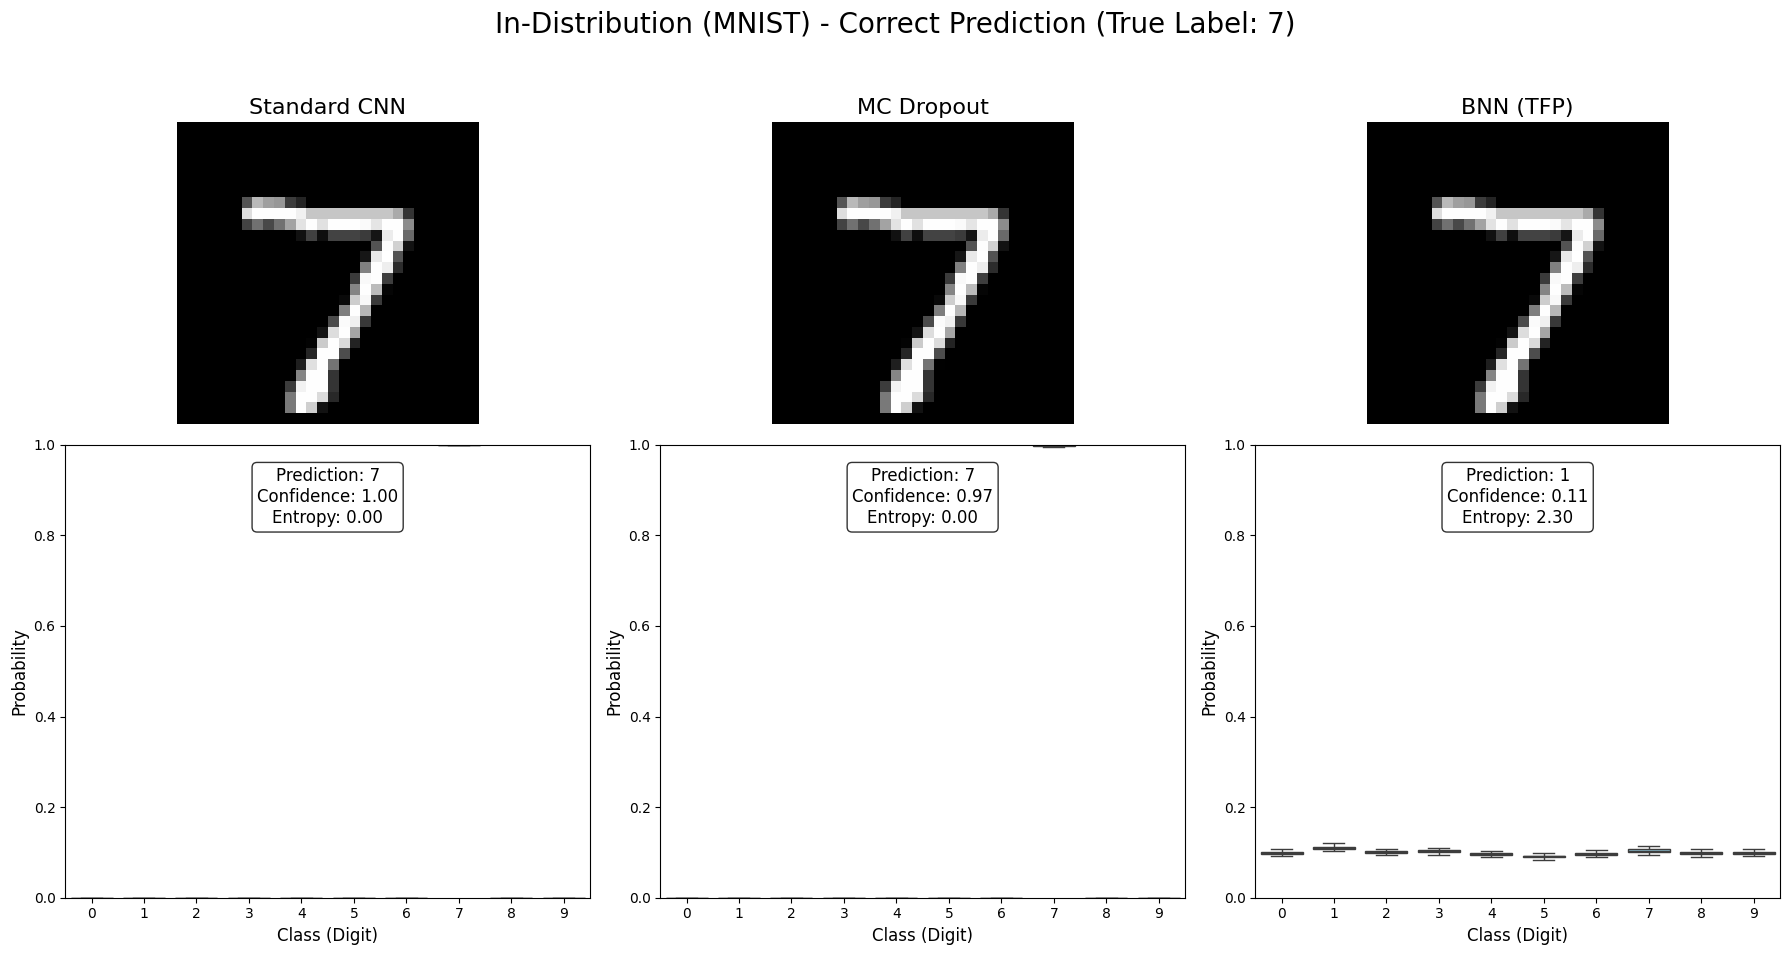

In [11]:
# ---
# 6.1. EVALUATION: IN-DISTRIBUTION (MNIST)
# ---

# Get a batch of MNIST test data
x_batch_mnist, y_batch_mnist = next(iter(test_dataset_mnist))

# Get predictions from all models
probs_standard_mnist = predict_standard(model_standard, x_batch_mnist)
probs_mc_mnist = predict_mc_dropout(model_mc_dropout, x_batch_mnist)
probs_bnn_mnist = predict_bnn(model_bnn, x_batch_mnist)

# --- START OF FIX ---

# Find an example the Standard CNN gets WRONG
preds_standard_mean = tf.reduce_mean(probs_standard_mnist, axis=0)
preds_standard_class = tf.argmax(preds_standard_mean, axis=1)
wrong_indices = tf.where(preds_standard_class != y_batch_mnist)

# Check if there are any wrong predictions in this batch
if tf.shape(wrong_indices)[0] == 0:
    print("\n--- Model got 100% accuracy on this batch! Analyzing a CORRECT prediction instead. ---")
    idx_to_analyze = 0 # Just pick the first image
    analysis_title = "In-Distribution (MNIST) - Correct Prediction"
else:
    print(f"\n--- Analyzing an INCORRECT MNIST Prediction ---")
    idx_to_analyze = wrong_indices[0, 0].numpy() # Get first wrong index
    analysis_title = "In-Distribution (MNIST) - Incorrect Prediction"

print(f"Analyzing Image Index: {idx_to_analyze}")
print(f"True Label: {y_batch_mnist[idx_to_analyze].numpy()}")

# --- END OF FIX ---


# Get the probs for this single image from all 3 models
# Transpose to (model, n_samples, 10)
all_probs_to_plot = [
    probs_standard_mnist[:, idx_to_analyze, :],
    probs_mc_mnist[:, idx_to_analyze, :],
    probs_bnn_mnist[:, idx_to_analyze, :]
]

plot_uncertainty(
    x_batch_mnist[idx_to_analyze, ..., 0],
    all_probs_to_plot,
    title=f"{analysis_title} (True Label: {y_batch_mnist[idx_to_analyze].numpy()})"
)

# 6.2 Evaluation: Out-of-Distribution (FASHION-MNIST)


--- Analyzing an Out-of-Distribution (Fashion-MNIST) Image ---
True Label: Ankle boot


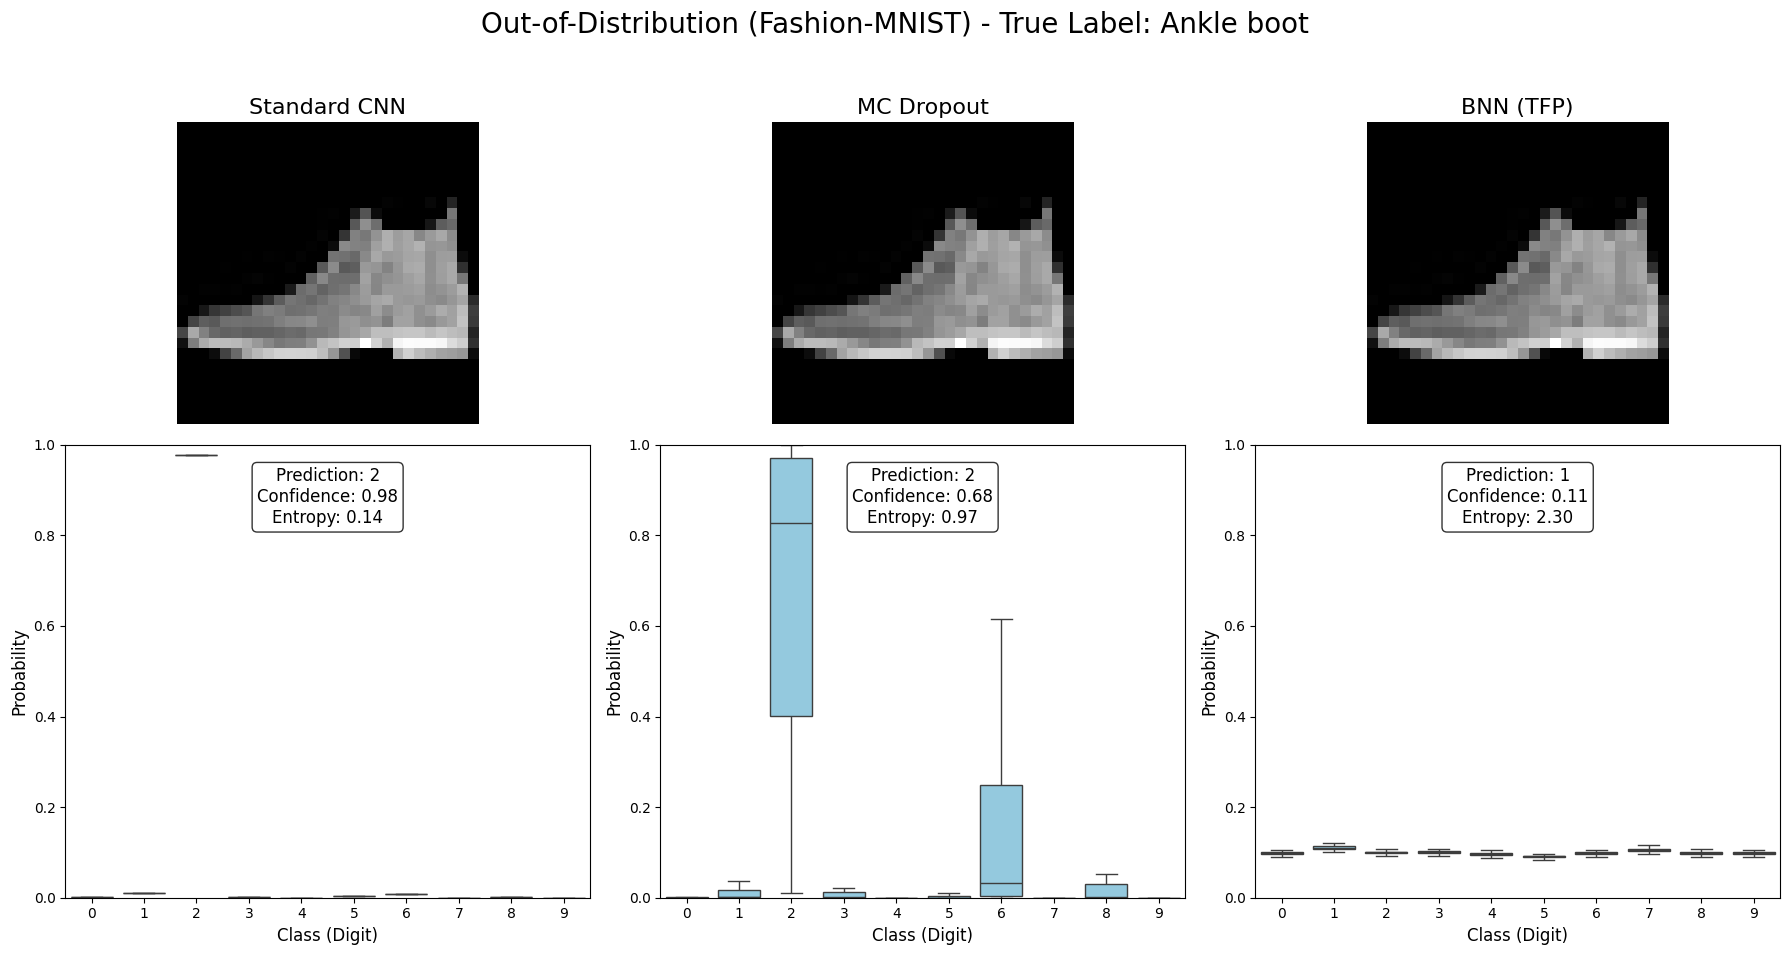

In [12]:
# ---
# 6.2. EVALUATION: OUT-OF-DISTRIBUTION (FASHION-MNIST)
# ---

# Get a batch of Fashion-MNIST test data
x_batch_fashion, y_batch_fashion = next(iter(test_dataset_fashion))

# Get predictions from all models
probs_standard_fashion = predict_standard(model_standard, x_batch_fashion)
probs_mc_fashion = predict_mc_dropout(model_mc_dropout, x_batch_fashion)
probs_bnn_fashion = predict_bnn(model_bnn, x_batch_fashion)

# Analyze the first image (e.g., a T-shirt or Shoe)
idx_ood = 0
fashion_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                   "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
true_fashion_label = fashion_labels[y_batch_fashion[idx_ood].numpy()]

print(f"\n--- Analyzing an Out-of-Distribution (Fashion-MNIST) Image ---")
print(f"True Label: {true_fashion_label}")

all_probs_ood = [
    probs_standard_fashion[:, idx_ood, :],
    probs_mc_fashion[:, idx_ood, :],
    probs_bnn_fashion[:, idx_ood, :]
]

plot_uncertainty(
    x_batch_fashion[idx_ood, ..., 0],
    all_probs_ood,
    title=f"Out-of-Distribution (Fashion-MNIST) - True Label: {true_fashion_label}"
)

# 6.3 Evaluation: Entropy Histograms

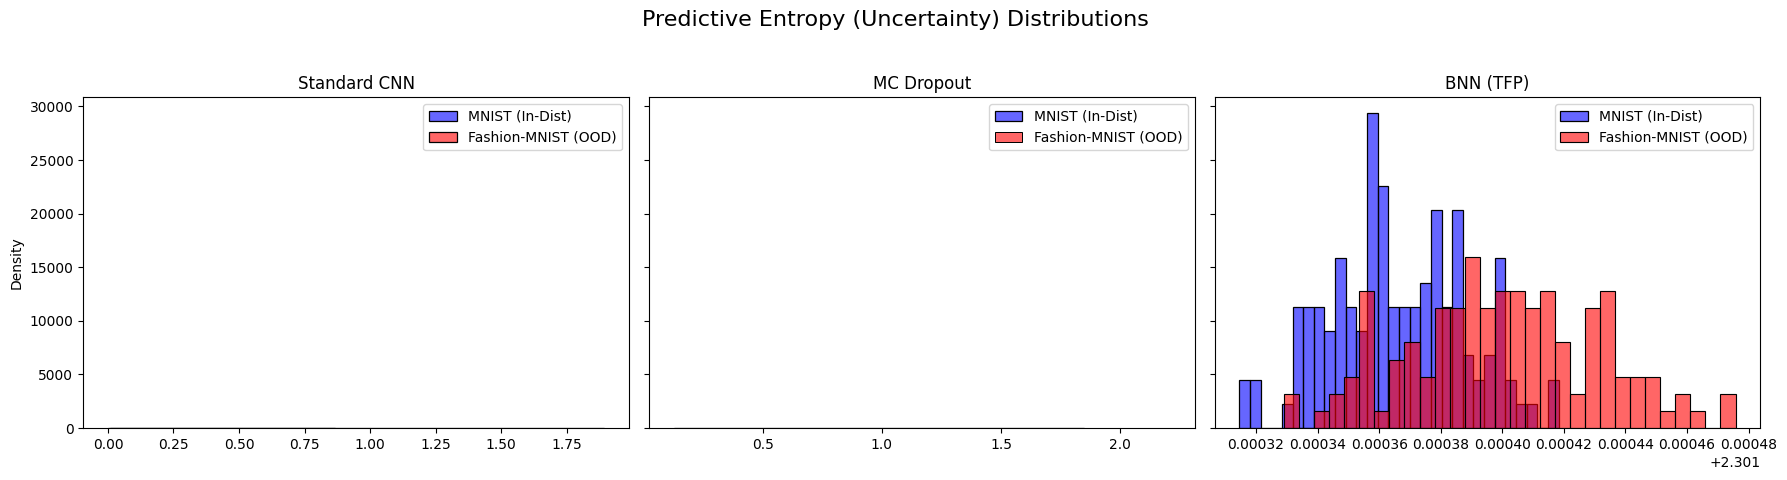

In [13]:
# ---
# 6.3. EVALUATION: ENTROPY HISTOGRAMS
# ---

# Calculate entropy for all test sets
entropy_standard_id = predictive_entropy(probs_standard_mnist)
entropy_mc_id = predictive_entropy(probs_mc_mnist)
entropy_bnn_id = predictive_entropy(probs_bnn_mnist)

entropy_standard_ood = predictive_entropy(probs_standard_fashion)
entropy_mc_ood = predictive_entropy(probs_mc_fashion)
entropy_bnn_ood = predictive_entropy(probs_bnn_fashion)

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle("Predictive Entropy (Uncertainty) Distributions", fontsize=16)

sns.histplot(entropy_standard_id, ax=axes[0], color='blue', label='MNIST (In-Dist)', bins=30, stat='density', alpha=0.6)
sns.histplot(entropy_standard_ood, ax=axes[0], color='red', label='Fashion-MNIST (OOD)', bins=30, stat='density', alpha=0.6)
axes[0].set_title("Standard CNN")
axes[0].legend()

sns.histplot(entropy_mc_id, ax=axes[1], color='blue', label='MNIST (In-Dist)', bins=30, stat='density', alpha=0.6)
sns.histplot(entropy_mc_ood, ax=axes[1], color='red', label='Fashion-MNIST (OOD)', bins=30, stat='density', alpha=0.6)
axes[1].set_title("MC Dropout")
axes[1].legend()

sns.histplot(entropy_bnn_id, ax=axes[2], color='blue', label='MNIST (In-Dist)', bins=30, stat='density', alpha=0.6)
sns.histplot(entropy_bnn_ood, ax=axes[2], color='red', label='Fashion-MNIST (OOD)', bins=30, stat='density', alpha=0.6)
axes[2].set_title("BNN (TFP)")
axes[2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()